# Dataset Preparation

## Download Training Data

In [1]:
# Download training images and masks (Ground Truth)
!mkdir -p /content/isic2016

!wget -O /content/isic2016/train_input.zip https://isic-archive.s3.amazonaws.com/challenges/2016/ISBI2016_ISIC_Part1_Training_Data.zip
!wget -O /content/isic2016/train_gt.zip https://isic-archive.s3.amazonaws.com/challenges/2016/ISBI2016_ISIC_Part1_Training_GroundTruth.zip


--2025-11-22 19:33:08--  https://isic-archive.s3.amazonaws.com/challenges/2016/ISBI2016_ISIC_Part1_Training_Data.zip
Resolving isic-archive.s3.amazonaws.com (isic-archive.s3.amazonaws.com)... 16.15.196.58, 16.182.69.105, 3.5.0.84, ...
Connecting to isic-archive.s3.amazonaws.com (isic-archive.s3.amazonaws.com)|16.15.196.58|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 631625308 (602M) [application/zip]
Saving to: ‘/content/isic2016/train_input.zip’

/content/isic2016/t 100%[===================>] 602.36M  17.9MB/s    in 38s     

2025-11-22 19:33:47 (15.9 MB/s) - ‘/content/isic2016/train_input.zip’ saved [631625308/631625308]

--2025-11-22 19:33:47--  https://isic-archive.s3.amazonaws.com/challenges/2016/ISBI2016_ISIC_Part1_Training_GroundTruth.zip
Resolving isic-archive.s3.amazonaws.com (isic-archive.s3.amazonaws.com)... 54.231.139.1, 52.216.58.57, 16.15.183.204, ...
Connecting to isic-archive.s3.amazonaws.com (isic-archive.s3.amazonaws.com)|54.231.139.1|:443

## Unzip Training Data

In [2]:
# Unzip both images and masks
!unzip -q /content/isic2016/train_input.zip -d /content/isic2016/
!unzip -q /content/isic2016/train_gt.zip -d /content/isic2016/


## Verify Dataset Contents

In [3]:
import os, glob

IMG_DIR = "/content/isic2016/ISBI2016_ISIC_Part1_Training_Data"
MSK_DIR = "/content/isic2016/ISBI2016_ISIC_Part1_Training_GroundTruth"

num_images = len(glob.glob(os.path.join(IMG_DIR, "*.jpg")))
num_masks  = len(glob.glob(os.path.join(MSK_DIR, "*.png")))

print("Number of images:", num_images)
print("Number of masks :", num_masks)

print("\nSample images:", glob.glob(os.path.join(IMG_DIR, '*.jpg'))[:3])
print("Sample masks :", glob.glob(os.path.join(MSK_DIR, '*.png'))[:3])


Number of images: 900
Number of masks : 900

Sample images: ['/content/isic2016/ISBI2016_ISIC_Part1_Training_Data/ISIC_0000364.jpg', '/content/isic2016/ISBI2016_ISIC_Part1_Training_Data/ISIC_0000095.jpg', '/content/isic2016/ISBI2016_ISIC_Part1_Training_Data/ISIC_0005548.jpg']
Sample masks : ['/content/isic2016/ISBI2016_ISIC_Part1_Training_GroundTruth/ISIC_0009895_Segmentation.png', '/content/isic2016/ISBI2016_ISIC_Part1_Training_GroundTruth/ISIC_0010351_Segmentation.png', '/content/isic2016/ISBI2016_ISIC_Part1_Training_GroundTruth/ISIC_0000140_Segmentation.png']


# Subset Creation (500 Images)

## Select 500 Random Images

In [4]:
import numpy as np

# Collect all available images
all_images = sorted(glob.glob(os.path.join(IMG_DIR, "*.jpg")))
print("Total available images:", len(all_images))

# Randomly select 500
np.random.seed(42)
subset_images = list(np.random.choice(all_images, size=500, replace=False))
print("Subset selected:", len(subset_images))


Total available images: 900
Subset selected: 500


## Copy Subset to New Folder

In [5]:
import shutil

SUB_ROOT = "/content/isic2016_subset"
SUB_IMG = os.path.join(SUB_ROOT, "images")
SUB_MSK = os.path.join(SUB_ROOT, "masks")
os.makedirs(SUB_IMG, exist_ok=True)
os.makedirs(SUB_MSK, exist_ok=True)

def mask_path_for(img_path):
    base = os.path.splitext(os.path.basename(img_path))[0]
    return os.path.join(MSK_DIR, f"{base}_Segmentation.png")

# Copy selected pairs
for img_path in subset_images:
    msk_path = mask_path_for(img_path)
    shutil.copy2(img_path, os.path.join(SUB_IMG, os.path.basename(img_path)))
    shutil.copy2(msk_path, os.path.join(SUB_MSK, os.path.basename(msk_path)))

print("Subset images:", len(glob.glob(os.path.join(SUB_IMG, '*.jpg'))))
print("Subset masks :", len(glob.glob(os.path.join(SUB_MSK, '*.png'))))


Subset images: 500
Subset masks : 500


## Quick Preview

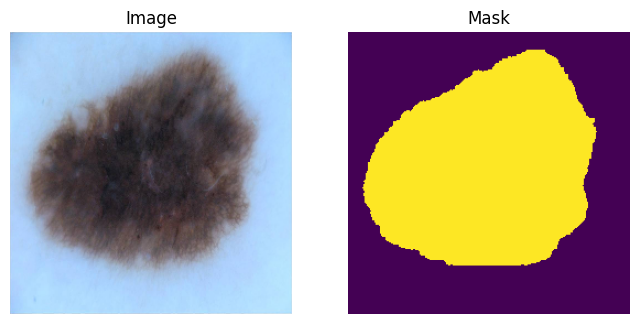

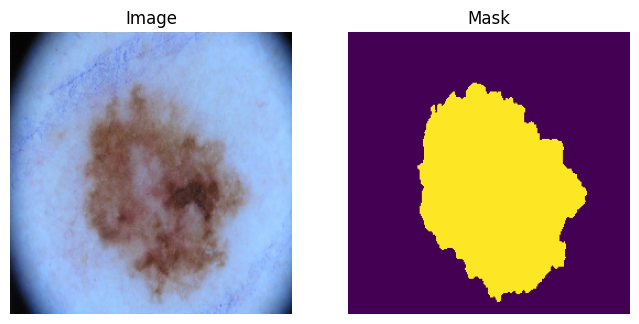

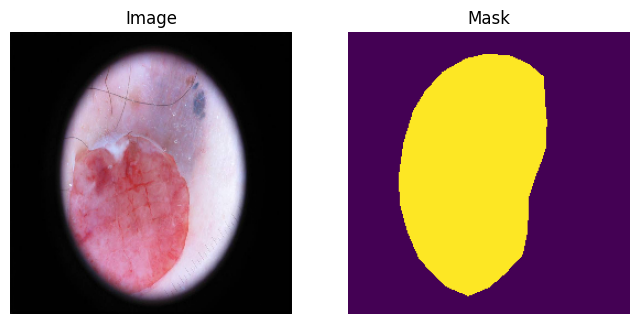

In [6]:
!pip install opencv-python
import cv2
import matplotlib.pyplot as plt

def show_pair(idx=0, size=256):
    imgs = sorted(glob.glob(os.path.join(SUB_IMG, "*.jpg")))
    img_path = imgs[idx]
    base = os.path.splitext(os.path.basename(img_path))[0]
    msk_path = os.path.join(SUB_MSK, f"{base}_Segmentation.png")

    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    msk = cv2.imread(msk_path, cv2.IMREAD_GRAYSCALE)

    img_disp = cv2.resize(img, (size, size))
    msk_disp = cv2.resize(msk, (size, size), interpolation=cv2.INTER_NEAREST)

    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1); plt.imshow(img_disp); plt.title("Image"); plt.axis("off")
    plt.subplot(1,2,2); plt.imshow(msk_disp); plt.title("Mask"); plt.axis("off")
    plt.show()

show_pair(0)
show_pair(1)
show_pair(2)


# Dataset and DataLoader

## Define Custom Dataset Class

In [7]:
from torch.utils.data import Dataset
import cv2
import torch
import os

class ISICDataset(Dataset):
    def __init__(self, image_paths, mask_dir, transform=None, cache_data=True):
        self.image_paths = image_paths
        self.mask_dir = mask_dir
        self.transform = transform
        self.cache_data = cache_data
        self.cache = {}

        if self.cache_data:
            print(f"Caching {len(image_paths)} images in memory...")
            for i, img_path in enumerate(image_paths):
                base = os.path.splitext(os.path.basename(img_path))[0]
                msk_path = os.path.join(self.mask_dir, f"{base}_Segmentation.png")

                # Read image and mask
                image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
                mask = cv2.imread(msk_path, cv2.IMREAD_GRAYSCALE)

                # Ensure mask is binary (0 or 1)
                mask = (mask > 0).astype("float32")

                self.cache[i] = (image, mask)
            print("Caching complete.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        if self.cache_data:
            image, mask = self.cache[idx]
        else:
            img_path = self.image_paths[idx]
            base = os.path.splitext(os.path.basename(img_path))[0]
            msk_path = os.path.join(self.mask_dir, f"{base}_Segmentation.png")

            # Read image and mask
            image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
            mask = cv2.imread(msk_path, cv2.IMREAD_GRAYSCALE)

            # Ensure mask is binary (0 or 1)
            mask = (mask > 0).astype("float32")

        # Apply augmentations / transforms
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]
        else:
            # Default conversion to tensor
            image = torch.from_numpy(image.transpose(2,0,1)).float() / 255.0
            mask = torch.from_numpy(mask).unsqueeze(0).float()

        return image, mask

## Create Train/Validation Split

In [8]:
from sklearn.model_selection import train_test_split

all_subset_images = sorted(glob.glob(os.path.join(SUB_IMG, "*.jpg")))

train_imgs, val_imgs = train_test_split(all_subset_images, test_size=0.2, random_state=42)
print("Train size:", len(train_imgs))
print("Val size:", len(val_imgs))


Train size: 400
Val size: 100


## Define Transforms (Albumentations)

In [9]:
!pip install albumentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_tfms = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Normalize(),
    ToTensorV2()
])

val_tfms = A.Compose([
    A.Resize(256, 256),
    A.Normalize(),
    ToTensorV2()
])

## Create DataLoaders

In [10]:
from torch.utils.data import DataLoader

# Enable caching for faster training
train_ds = ISICDataset(train_imgs, SUB_MSK, transform=train_tfms, cache_data=True)
val_ds   = ISICDataset(val_imgs, SUB_MSK, transform=val_tfms, cache_data=True)

# Update DataLoader to avoid multiprocessing issues
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=0)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))

Caching 400 images in memory...
Caching complete.
Caching 100 images in memory...
Caching complete.
Train batches: 50
Val batches: 13


## Preview a Batch

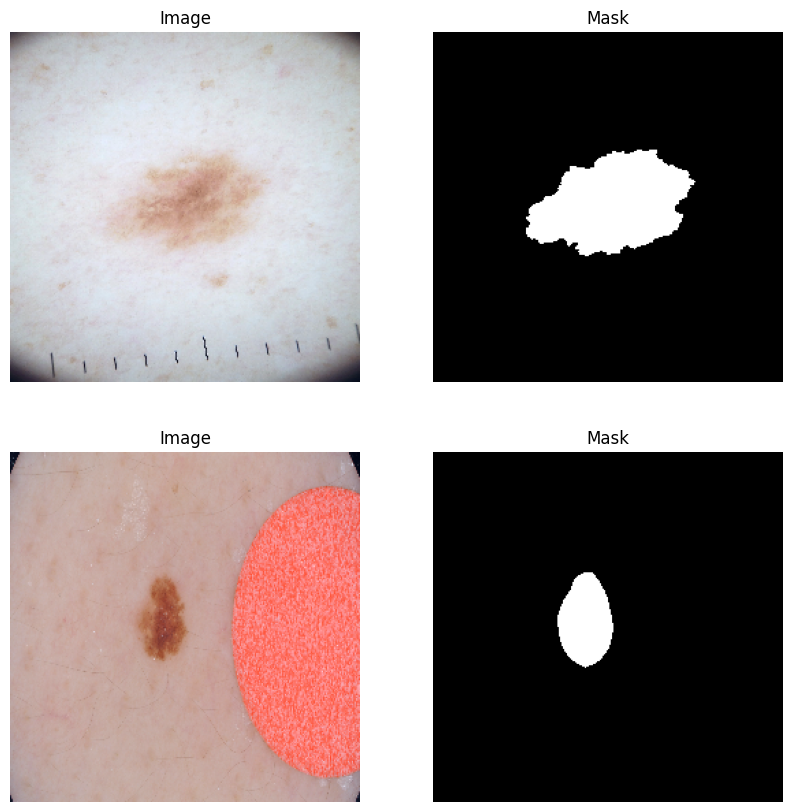

In [11]:
# Visualize One Batch
import matplotlib.pyplot as plt

# Helper function: unnormalize image tensor for visualization
def unnormalize(img_tensor):
    img = img_tensor.numpy().transpose((1,2,0))  # [C,H,W] -> [H,W,C]
    img = (img - img.min()) / (img.max() - img.min())  # scale to [0,1]
    return img

# Take one batch from train loader
try:
    images, masks = next(iter(train_loader))
except RuntimeError as e:
    print("Error loading batch. Try setting num_workers=0 in DataLoader.")
    raise e

plt.figure(figsize=(10,10))
for i in range(2):  # show first 2 samples
    # Unnormalize image for correct visualization
    img = unnormalize(images[i].cpu())
    mask = masks[i].squeeze().cpu().numpy()

    # Show image
    plt.subplot(2,2,2*i+1)
    plt.imshow(img)
    plt.title("Image")
    plt.axis("off")

    # Show mask
    plt.subplot(2,2,2*i+2)
    plt.imshow(mask, cmap="gray")
    plt.title("Mask")
    plt.axis("off")

plt.show()



## Visualize One Batch (Train + Validation)

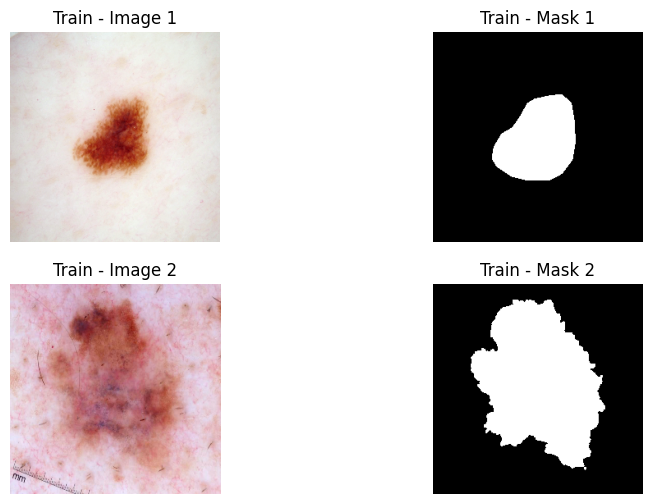

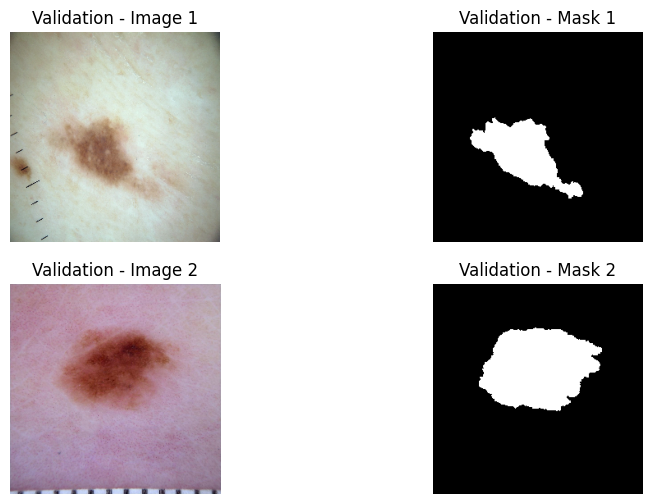

In [12]:
# Visualize batch from train and validation
import matplotlib.pyplot as plt

def visualize_batch(dataloader, title="Batch Samples"):
    images, masks = next(iter(dataloader))

    plt.figure(figsize=(10,6))
    for i in range(2):  # show 2 samples
        img = unnormalize(images[i].cpu())
        mask = masks[i].squeeze().cpu().numpy()

        # Image
        plt.subplot(2,2,2*i+1)
        plt.imshow(img)
        plt.title(f"{title} - Image {i+1}")
        plt.axis("off")

        # Mask
        plt.subplot(2,2,2*i+2)
        plt.imshow(mask, cmap="gray")
        plt.title(f"{title} - Mask {i+1}")
        plt.axis("off")

    plt.show()

# Show train batch
visualize_batch(train_loader, title="Train")

# Show validation batch
visualize_batch(val_loader, title="Validation")


# Define U-Net Model

In [13]:
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    """(Conv -> BN -> ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1):
        super(UNet, self).__init__()
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(256, 512))
        self.down4 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(512, 1024))

        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(1024, 512)
        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(512, 256)
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(256, 128)
        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv4 = DoubleConv(128, 64)

        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5)
        x = self.conv1(torch.cat([x, x4], dim=1))
        x = self.up2(x)
        x = self.conv2(torch.cat([x, x3], dim=1))
        x = self.up3(x)
        x = self.conv3(torch.cat([x, x2], dim=1))
        x = self.up4(x)
        x = self.conv4(torch.cat([x, x1], dim=1))

        logits = self.outc(x)
        return self.sigmoid(logits)


# Define Loss Function and Optimizer

In [14]:
# Define Loss Function and Optimizer

import torch.optim as optim

# Dice Loss
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        preds = preds.view(-1)
        targets = targets.view(-1)
        intersection = (preds * targets).sum()
        dice = (2. * intersection + self.smooth) / (preds.sum() + targets.sum() + self.smooth)
        return 1 - dice

# BCE Loss
bce_loss = nn.BCELoss()
dice_loss = DiceLoss()

def loss_fn(preds, targets):
    return 0.5 * bce_loss(preds, targets) + 0.5 * dice_loss(preds, targets)

# Initialize model & optimizer
# Check for MPS (Apple Silicon GPU) support
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

model = UNet(n_channels=3, n_classes=1).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

print("Model, loss function, and optimizer are ready!")

Using device: cuda
Model, loss function, and optimizer are ready!


# Define Evaluation Metrics

In [15]:
# Define Evaluation Metrics

def dice_coef(preds, targets, smooth=1.0):
    preds = preds.view(-1)
    targets = targets.view(-1)
    intersection = (preds * targets).sum()
    return (2. * intersection + smooth) / (preds.sum() + targets.sum() + smooth)

def iou_score(preds, targets, smooth=1.0):
    preds = preds.view(-1)
    targets = targets.view(-1)
    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum() - intersection
    return (intersection + smooth) / (union + smooth)


# Training Loop

In [16]:
# Define Evaluation Metrics
# -------------------------
import time

def dice_coef(preds, targets, smooth=1.0):
    preds = preds.view(-1)
    targets = targets.view(-1)
    intersection = (preds * targets).sum()
    return (2. * intersection + smooth) / (preds.sum() + targets.sum() + smooth)

def iou_score(preds, targets, smooth=1.0):
    preds = preds.view(-1)
    targets = targets.view(-1)
    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum() - intersection
    return (intersection + smooth) / (union + smooth)
# --------------------------

# Training Loop

def train_model(model, train_loader, val_loader, optimizer, num_epochs=10):
    history = {"train_loss": [], "val_loss": [], "val_dice": [], "val_iou": []}

    print(f"Starting training for {num_epochs} epochs on {device}...")

    for epoch in range(1, num_epochs+1):
        epoch_start = time.time()
        print(f"\n{'='*20} Epoch {epoch}/{num_epochs} {'='*20}")

        # Training Phase
        model.train()
        train_loss = 0.0
        train_start = time.time()

        num_batches = len(train_loader)
        print(f"Training phase: {num_batches} batches")

        for i, (images, masks) in enumerate(train_loader):
            batch_start = time.time()
            images, masks = images.to(device), masks.to(device).unsqueeze(1)

            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, masks)

            # Backward + optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Print progress every 10 batches or for the first batch
            if (i + 1) % 10 == 0 or i == 0:
                batch_time = time.time() - batch_start
                print(f"  Batch {i+1}/{num_batches} processed in {batch_time:.4f}s | Loss: {loss.item():.4f}")

        train_duration = time.time() - train_start
        print(f"Training phase completed in {train_duration:.2f}s")

        # Validation Phase
        model.eval()
        val_loss, val_dices, val_ious = 0.0, [], []
        val_start = time.time()
        print("Starting validation phase...")

        with torch.no_grad():
            for i, (images, masks) in enumerate(val_loader):
                images, masks = images.to(device), masks.to(device).unsqueeze(1)
                outputs = model(images)

                val_loss += loss_fn(outputs, masks).item()

                # Metrics
                preds = (outputs > 0.5).float()
                val_dices.append(dice_coef(preds, masks).item())
                val_ious.append(iou_score(preds, masks).item())

        val_duration = time.time() - val_start
        print(f"Validation phase completed in {val_duration:.2f}s")

        # Averages
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        val_dice = sum(val_dices) / len(val_dices)
        val_iou = sum(val_ious) / len(val_ious)

        # Save history
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["val_dice"].append(val_dice)
        history["val_iou"].append(val_iou)

        epoch_duration = time.time() - epoch_start
        print(f"-"*60)
        print(f"Epoch [{epoch}/{num_epochs}] Summary:")
        print(f"  Duration: {epoch_duration:.2f}s")
        print(f"  Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        print(f"  Val Dice: {val_dice:.4f} | Val IoU: {val_iou:.4f}")
        print(f"-"*60)

    return history


#  Run training
history = train_model(model, train_loader, val_loader, optimizer, num_epochs=20)

Starting training for 20 epochs on cuda...

==================== Epoch 1/20 ====================
Training phase: 50 batches
  Batch 1/50 processed in 2.6151s | Loss: 0.6463
  Batch 10/50 processed in 0.4508s | Loss: 0.4699
  Batch 20/50 processed in 0.4512s | Loss: 0.4541
  Batch 30/50 processed in 0.4550s | Loss: 0.5460
  Batch 40/50 processed in 0.4558s | Loss: 0.3608
  Batch 50/50 processed in 0.4578s | Loss: 0.3851
Training phase completed in 25.67s
Starting validation phase...
Validation phase completed in 2.16s
------------------------------------------------------------
Epoch [1/20] Summary:
  Duration: 27.84s
  Train Loss: 0.4712 | Val Loss: 0.4045
  Val Dice: 0.7563 | Val IoU: 0.6136
------------------------------------------------------------

==================== Epoch 2/20 ====================
Training phase: 50 batches
  Batch 1/50 processed in 0.4587s | Loss: 0.3595
  Batch 10/50 processed in 0.4615s | Loss: 0.2912
  Batch 20/50 processed in 0.4611s | Loss: 0.4585
  Batch

# Training History Graphs

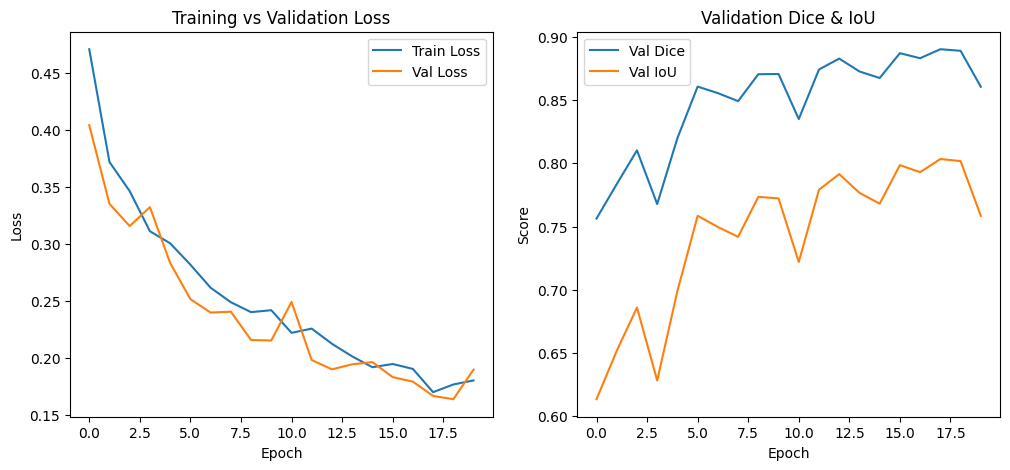

In [17]:
# Training History Graphs


import matplotlib.pyplot as plt

# Plot Loss (Train vs Validation)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

# Plot Dice & IoU
plt.subplot(1,2,2)
plt.plot(history["val_dice"], label="Val Dice")
plt.plot(history["val_iou"], label="Val IoU")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Validation Dice & IoU")
plt.legend()

plt.show()


# Precision, Recall, F1 and Confusion Matrix

Validation Precision: 0.9626
Validation Recall: 0.7838
Validation F1-score: 0.8640


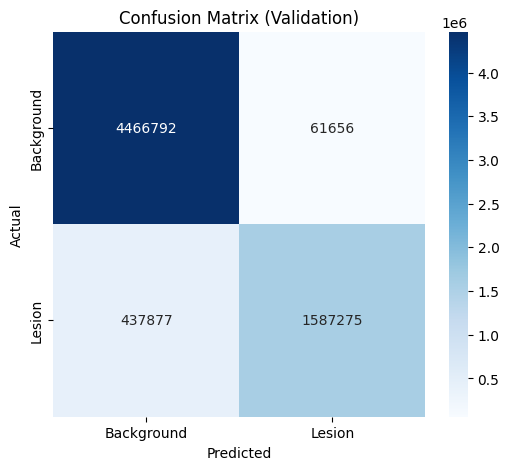

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Precision, Recall, F1 functions
def precision_score(preds, targets, smooth=1e-6):
    preds = (preds > 0.5).float().view(-1)
    targets = targets.view(-1)
    TP = (preds * targets).sum()
    FP = (preds * (1 - targets)).sum()
    return (TP + smooth) / (TP + FP + smooth)

def recall_score(preds, targets, smooth=1e-6):
    preds = (preds > 0.5).float().view(-1)
    targets = targets.view(-1)
    TP = (preds * targets).sum()
    FN = ((1 - preds) * targets).sum()
    return (TP + smooth) / (TP + FN + smooth)

def f1_score(preds, targets, smooth=1e-6):
    prec = precision_score(preds, targets, smooth)
    rec = recall_score(preds, targets, smooth)
    return 2 * (prec * rec) / (prec + rec + smooth)

# Evaluation on the validation set
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        preds = (outputs > 0.5).float()

        all_preds.append(preds.cpu().numpy().flatten())
        all_targets.append(masks.cpu().numpy().flatten())

all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

# Metric Results
prec = precision_score(torch.tensor(all_preds), torch.tensor(all_targets))
rec = recall_score(torch.tensor(all_preds), torch.tensor(all_targets))
f1 = f1_score(torch.tensor(all_preds), torch.tensor(all_targets))

print(f"Validation Precision: {prec:.4f}")
print(f"Validation Recall: {rec:.4f}")
print(f"Validation F1-score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Background","Lesion"], yticklabels=["Background","Lesion"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Validation)")
plt.show()


# Prediction Visualization (Model Predictions vs Ground Truth)

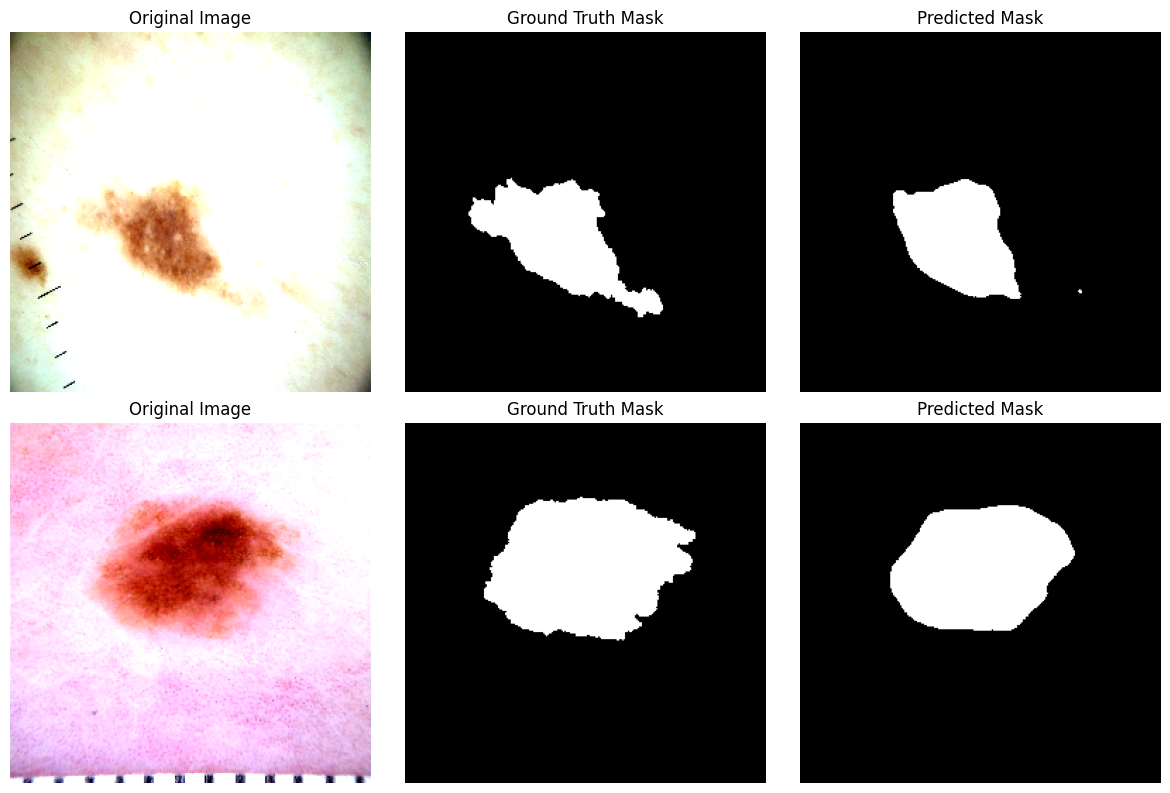

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Function to unnormalize images for visualization
def unnormalize(img):
    img = img.cpu().numpy().transpose(1, 2, 0)  # CHW -> HWC
    img = (img * 0.5) + 0.5   # reverse normalization (mean=0.5, std=0.5)
    img = np.clip(img, 0, 1)
    return img

# Show sample predictions
model.eval()
with torch.no_grad():
    images, masks = next(iter(val_loader))
    images, masks = images.to(device), masks.to(device)
    outputs = model(images)
    preds = (outputs > 0.5).float()

    plt.figure(figsize=(12, 8))
    for i in range(2):
        # Original image (unnormalized)
        plt.subplot(2, 3, i*3+1)
        plt.imshow(unnormalize(images[i]))
        plt.title("Original Image")
        plt.axis("off")

        # Ground truth mask
        plt.subplot(2, 3, i*3+2)
        plt.imshow(masks[i].cpu().squeeze(), cmap="gray")
        plt.title("Ground Truth Mask")
        plt.axis("off")

        # Predicted mask
        plt.subplot(2, 3, i*3+3)
        plt.imshow(preds[i].cpu().squeeze(), cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()
